In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
import sys
sys.path.append('../src')

import anndata
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import seaborn as sns
import torch
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from scipy.stats import pearsonr

In [40]:
from spaceoracle.models.estimators import ViTEstimatorV2

In [41]:
from spaceoracle.callbacks.simulation_callback import SimulationBetaCallbackV2
from spaceoracle.callbacks.fixtures.simulator import SimulatedDataV2

In [97]:
# Simulated data pt1

sim_data = SimulatedDataV2(ntfs=20, clusters=6)
estimator = ViTEstimatorV2(sim_data.adata, target_gene='target_gene', 
                        regulators=sim_data.tf_labels, n_clusters=sim_data.clusters)

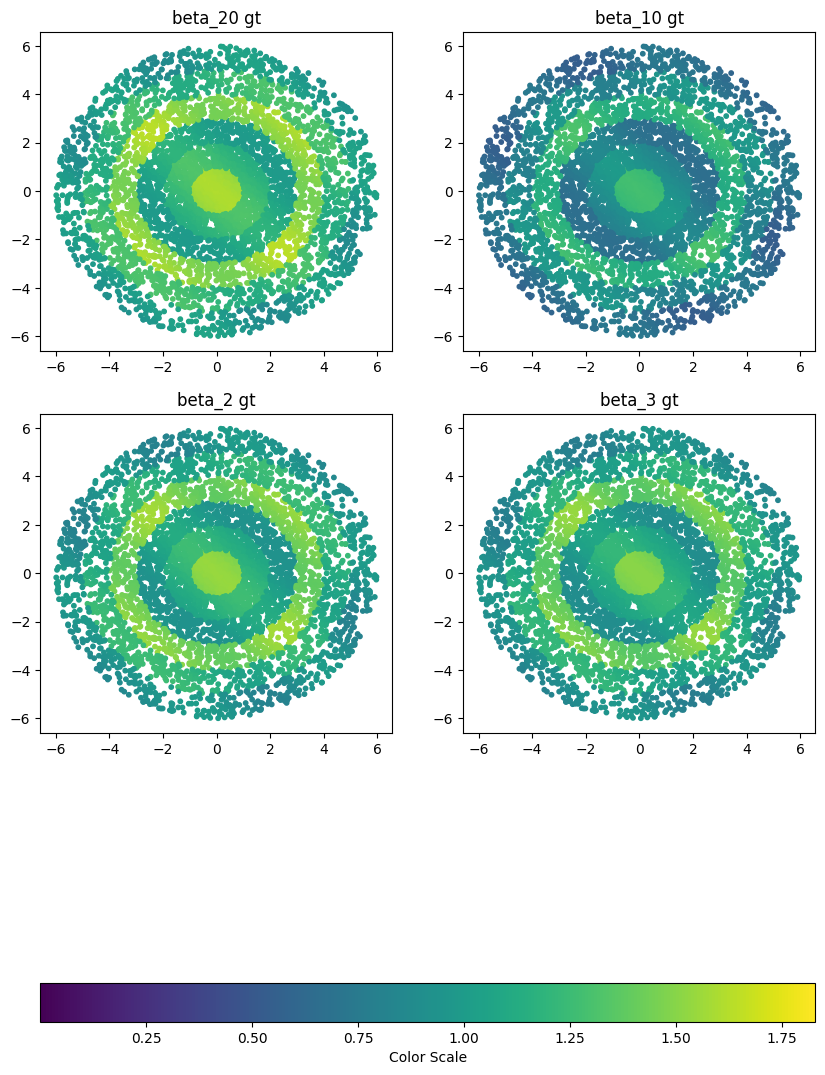

In [98]:
hot_beta = 20
cool_beta = 10
warm_beta = 2
big_beta = 3

fig, axes = plt.subplots(2, 2, figsize=(10, 13))
axes = axes.flatten()
vmin = np.min(sim_data.betas)
vmax = np.max(sim_data.betas)

sc1 = axes[0].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.betas[:, hot_beta], vmin=vmin, vmax=vmax, s=10)
axes[0].set_title(f"beta_{hot_beta} gt")

sc2 = axes[1].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.betas[:, cool_beta], vmin=vmin, vmax=vmax, s=10)
axes[1].set_title(f"beta_{cool_beta} gt")

sc3 = axes[2].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.betas[:, warm_beta], vmin=vmin, vmax=vmax, s=10)
axes[2].set_title(f"beta_{warm_beta} gt")

sc4 = axes[3].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.betas[:, big_beta], vmin=vmin, vmax=vmax, s=10)
axes[3].set_title(f"beta_{big_beta} gt")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

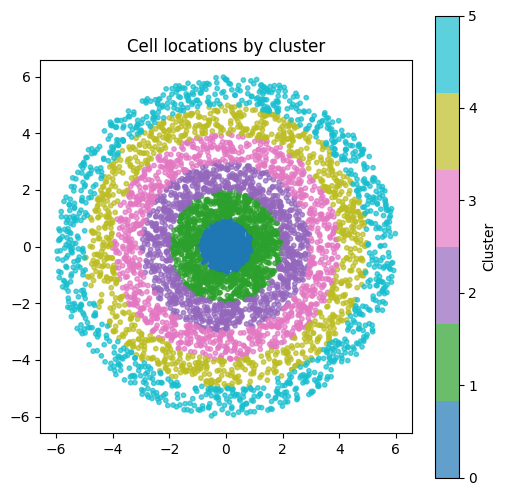

In [75]:
cmap = mcolors.ListedColormap(plt.cm.get_cmap('tab10', sim_data.clusters).colors)
scatter = plt.scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.labels, cmap=cmap, s=10, alpha=0.7)

plt.colorbar(scatter, label="Cluster")

plt.title('Cell locations by cluster')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()


[cuda] MSE: 0.0135 | Baseline: 3.1016: 100%|██████████| 20/20 [00:43<00:00,  2.19s/it]

Best model at 16/20


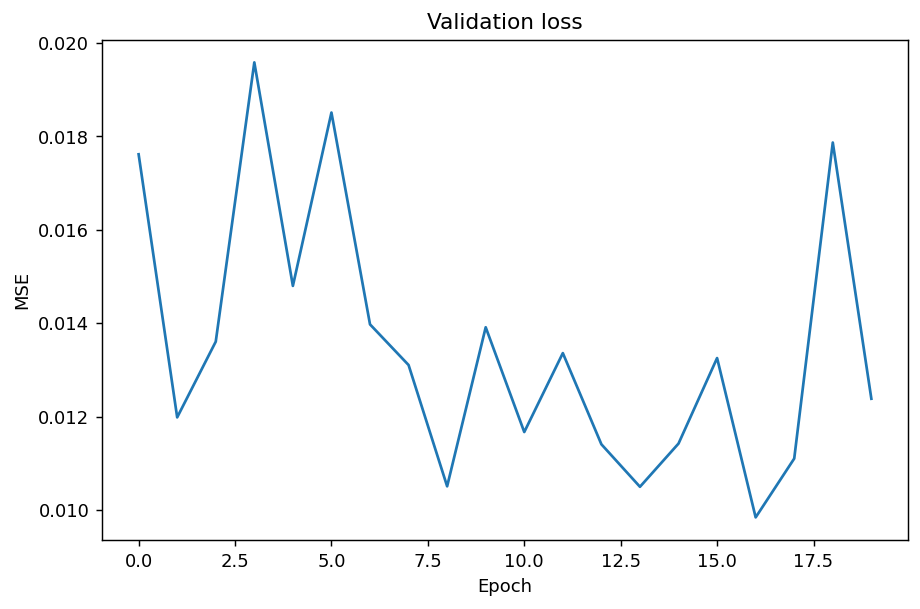

In [7]:
estimator.fit(
    annot='sim_cluster', 
    max_epochs=20, 
    learning_rate=0.01, 
    spatial_dim=64,
    batch_size=32,
    init_betas='ones',
    mode='train_test',
    rotate_maps=True,
    regularize=False,
    n_patches=16, n_heads=2, n_blocks=2, hidden_d=16
)

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams['figure.dpi'] = 130
plt.plot(estimator.losses)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Validation loss')
plt.show()

In [8]:
check_betas = SimulationBetaCallbackV2()

with torch.no_grad():
    beta_pred = estimator.get_betas(
        np.array(sim_data.adata.obsm['spatial']),
        np.array(sim_data.adata.obs['sim_cluster']),
    )

    y_pred = estimator.predict_y(
        estimator.model, 
        torch.from_numpy(beta_pred).cuda(), 
        torch.from_numpy(sim_data.adata.to_df()[estimator.regulators].values).cuda()).cpu().numpy()

check_betas(beta_pred, sim_data.betas)

{'beta0': -0.00617338002240771,
 'beta1': 0.9612952865937745,
 'beta2': 0.9750045838145704,
 'beta3': 0.9725605894409566,
 'beta4': 0.9517309531492559,
 'beta5': 0.9683777582700162,
 'beta6': 0.9487123626205762,
 'beta7': 0.9737534517615567,
 'beta8': 0.9493154097358498,
 'beta9': 0.9711186244525719,
 'beta10': 0.9375565717978989,
 'beta11': 0.9123410694841076,
 'beta12': 0.9739755886888892,
 'beta13': 0.9440141496149834,
 'beta14': 0.9568304256406324,
 'beta15': 0.9745770576253007,
 'beta16': 0.9650058144166658,
 'beta17': 0.9712937023017636,
 'beta18': 0.9439932281561156,
 'beta19': 0.9780881309742435,
 'beta20': 0.9757365168558136}

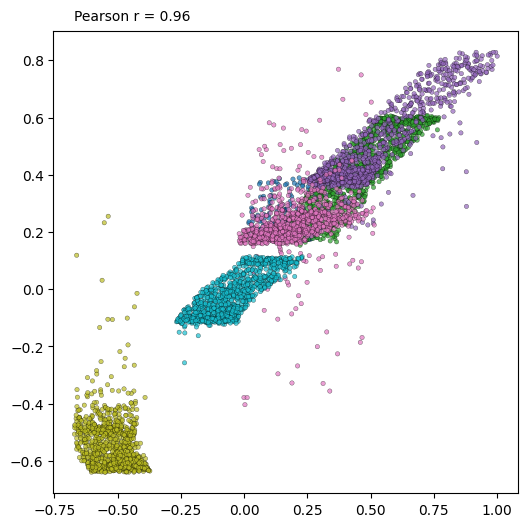

In [9]:
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams['figure.dpi'] = 100
y = sim_data.y
sns.scatterplot(
    x=y.reshape(-1), 
    y=y_pred.reshape(-1), s=10, 
    c=sim_data.adata.obs['sim_cluster'].values[:], cmap=cmap, edgecolor='black', linewidth=0.25, alpha=0.7)

corr, _ = pearsonr(y.reshape(-1), y_pred.reshape(-1))
plt.text(
    x=y.min(), 
    y=y_pred.max()+0.15, 
    s=f'Pearson r = {corr:.2f}', 
    fontsize=10, 
    fontname='DejaVu Sans',
    ha='left',
    va='top'
)
plt.show()

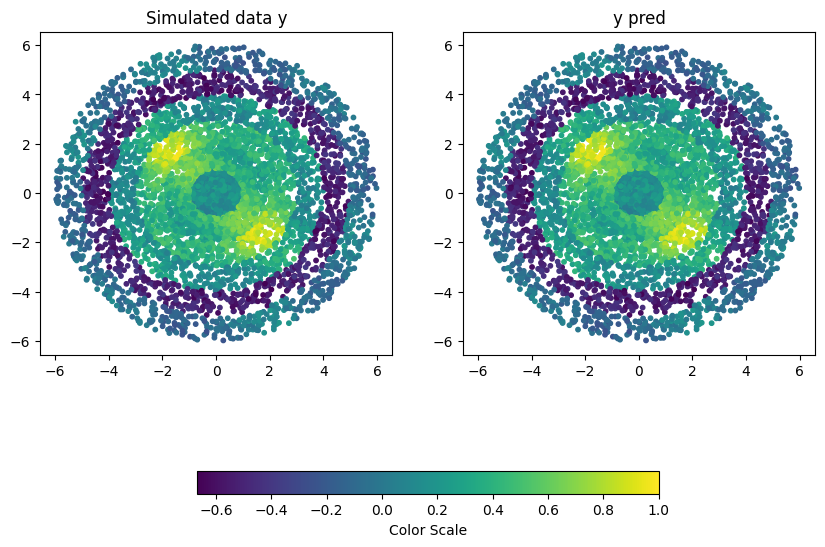

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

vmin = min(np.min(sim_data.y), np.min(y_pred))
vmax = max(np.max(sim_data.y), np.max(y_pred))

sc1 = axes[0].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[0].set_title("Simulated data y")

sc2 = axes[1].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[1].set_title("y pred")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

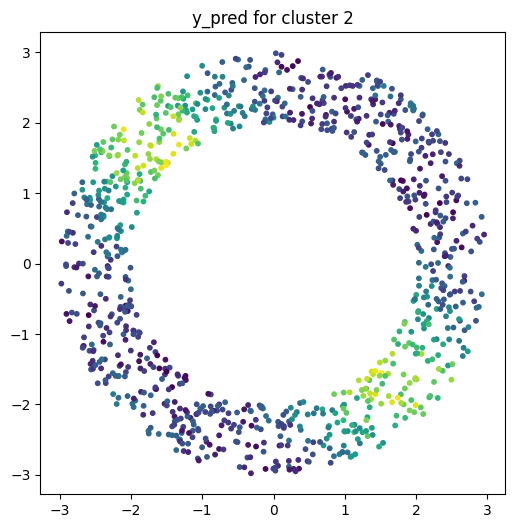

In [11]:
cool_cluster = 2
indices = np.argwhere(sim_data.labels == cool_cluster).flatten()
plt.scatter(sim_data.xy[:, 0][indices], sim_data.xy[:, 1][indices], c=sim_data.y[indices], s=10)
_ = plt.title(f'y_pred for cluster {cool_cluster}')

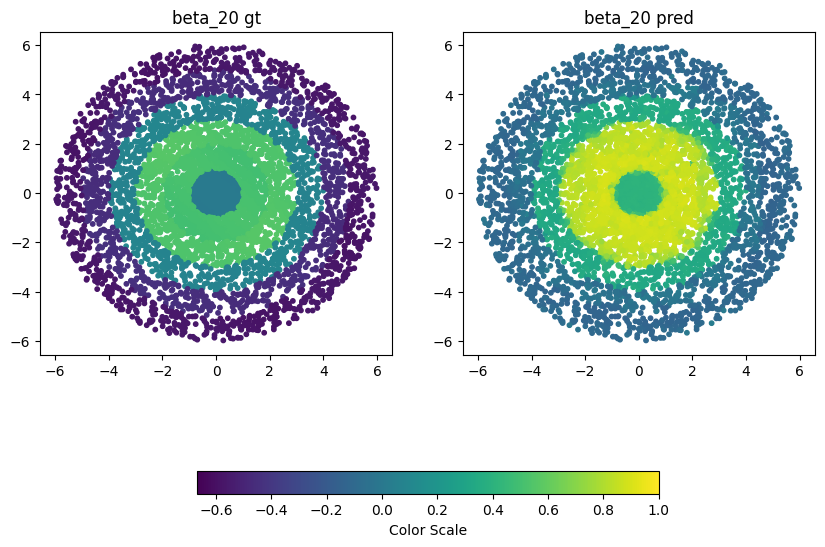

In [12]:
hot_beta = 20

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
vmin = min(np.min(sim_data.y), np.min(y_pred))
vmax = max(np.max(sim_data.y), np.max(y_pred))

sc1 = axes[0].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.betas[:, hot_beta], vmin=vmin, vmax=vmax, s=10)
axes[0].set_title(f"beta_{hot_beta} gt")

sc2 = axes[1].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=beta_pred[:, hot_beta], vmin=vmin, vmax=vmax, s=10)
axes[1].set_title(f"beta_{hot_beta} pred")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

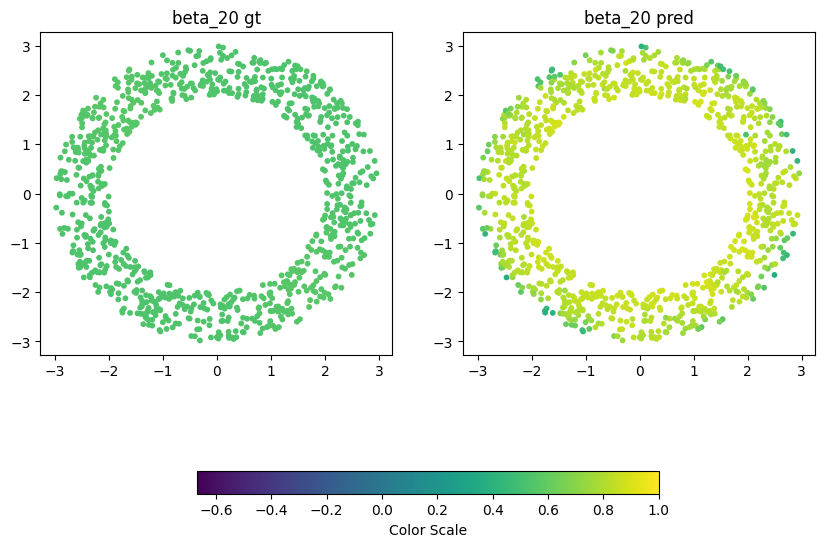

In [13]:
hot_beta = 20
cool_cluster = 2
indices = np.argwhere(sim_data.labels == cool_cluster).flatten()

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
vmin = min(np.min(sim_data.y), np.min(y_pred))
vmax = max(np.max(sim_data.y), np.max(y_pred))

sc1 = axes[0].scatter(sim_data.xy[:, 0][indices], sim_data.xy[:, 1][indices], 
                    c=sim_data.betas[:, hot_beta][indices], vmin=vmin, vmax=vmax, s=10)
axes[0].set_title(f"beta_{hot_beta} gt")

sc2 = axes[1].scatter(sim_data.xy[:, 0][indices], sim_data.xy[:, 1][indices], 
                    c=beta_pred[:, hot_beta][indices], vmin=vmin, vmax=vmax, s=10)
axes[1].set_title(f"beta_{hot_beta} pred")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

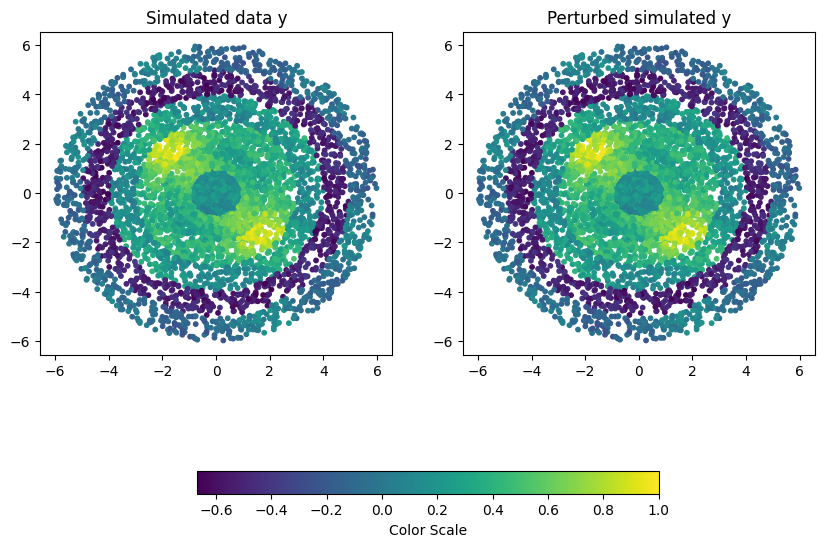

In [14]:
# Simulate KO

tf_ko = 'tf_20'
psim_data = check_betas.perturb(sim_data, tf_ko)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
vmin = min(np.min(psim_data.y), np.min(sim_data.y))
vmax = max(np.max(psim_data.y), np.max(sim_data.y))

sc1 = axes[0].scatter(psim_data.xy[:, 0], psim_data.xy[:, 1], c=sim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[0].set_title("Simulated data y")

sc2 = axes[1].scatter(psim_data.xy[:, 0], psim_data.xy[:, 1], c=psim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[1].set_title("Perturbed simulated y")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

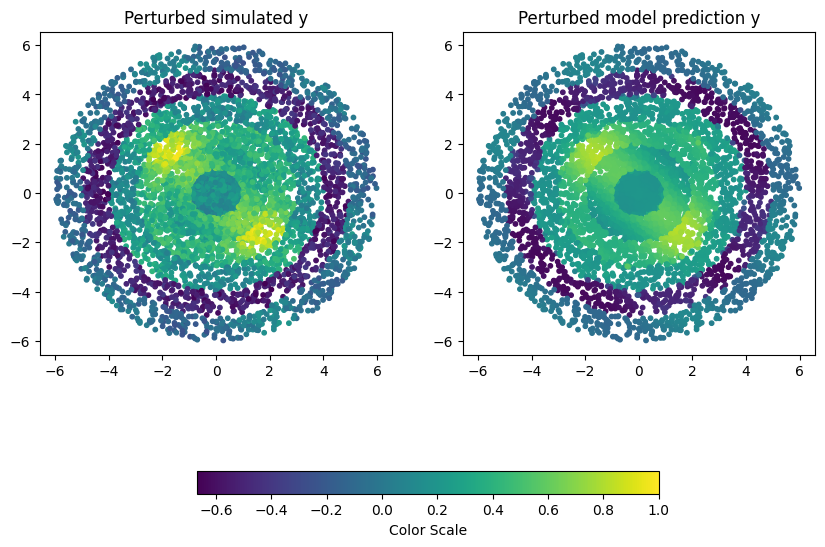

In [15]:
# Model prediction of KO

py_pred = estimator.predict_y(
        estimator.model, 
        torch.from_numpy(beta_pred).cuda(), 
        torch.from_numpy(psim_data.adata.to_df()[estimator.regulators].values).cuda()).cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

vmin = min(np.min(py_pred), np.min(psim_data.y))
vmax = max(np.max(py_pred), np.max(psim_data.y))

sc1 = axes[0].scatter(psim_data.xy[:, 0], psim_data.xy[:, 1], c=psim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[0].set_title("Perturbed simulated y")

sc2 = axes[1].scatter(psim_data.xy[:, 0], psim_data.xy[:, 1], c=py_pred, vmin=vmin, vmax=vmax, s=10)
axes[1].set_title("Perturbed model prediction y")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

In [16]:
# Simulated Data pt2

sim_data = SimulatedDataV2(ntfs=20, clusters=6, position='wave')
estimator = ViTEstimatorV2(sim_data.adata, target_gene='target_gene', 
                        regulators=sim_data.tf_labels, n_clusters=sim_data.clusters)

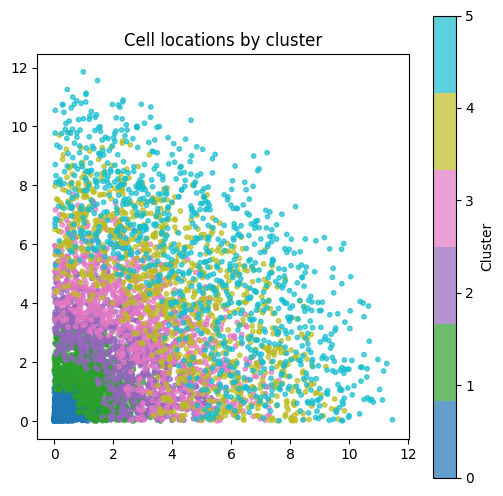

In [17]:
plt.figure(figsize=(6,6))

cmap = mcolors.ListedColormap(plt.cm.get_cmap('tab10', sim_data.clusters).colors)
scatter = plt.scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.labels, cmap=cmap, s=10, alpha=0.7)

plt.colorbar(scatter, label="Cluster")

plt.title('Cell locations by cluster')
plt.gca().set_aspect('equal', adjustable='box')

plt.show()


[cuda] MSE: 0.0759 | Baseline: 3.0914: 100%|██████████| 100/100 [03:45<00:00,  2.26s/it]

Best model at 41/100


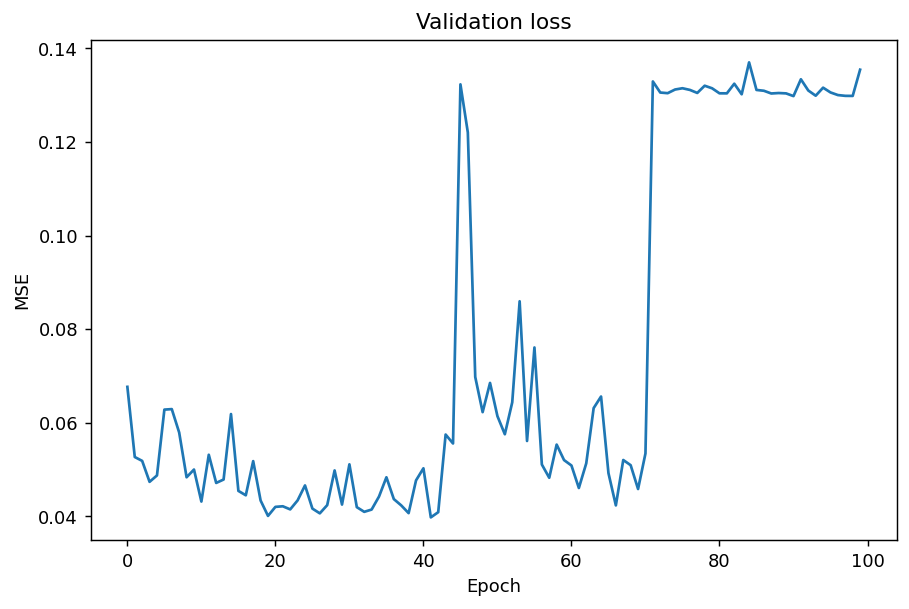

In [18]:
estimator.fit(
    annot='sim_cluster', 
    max_epochs=100, 
    learning_rate=0.01, 
    spatial_dim=64,
    batch_size=32,
    init_betas='ones',
    mode='train_test',
    rotate_maps=True,
    regularize=False,
    n_patches=16, n_heads=2, n_blocks=2, hidden_d=16
)

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams['figure.dpi'] = 130
plt.plot(estimator.losses)
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Validation loss')
plt.show()

In [19]:
check_betas = SimulationBetaCallbackV2()

with torch.no_grad():
    beta_pred = estimator.get_betas(
        np.array(sim_data.adata.obsm['spatial']),
        np.array(sim_data.adata.obs['sim_cluster']),
    )

    y_pred = estimator.predict_y(
        estimator.model, 
        torch.from_numpy(beta_pred).cuda(), 
        torch.from_numpy(sim_data.adata.to_df()[estimator.regulators].values).cuda()).cpu().numpy()

check_betas(beta_pred, sim_data.betas)

{'beta0': -0.006948465307563857,
 'beta1': 0.03911013094082392,
 'beta2': -0.019192454073994496,
 'beta3': -0.04847314642940698,
 'beta4': 0.0368214443531099,
 'beta5': 0.10313761568821381,
 'beta6': 0.151582522571018,
 'beta7': 0.07717083699263258,
 'beta8': 0.06379568023059817,
 'beta9': 0.38178256864667937,
 'beta10': 0.21369125103213926,
 'beta11': 0.12330770107288459,
 'beta12': 0.0565117794436105,
 'beta13': -0.02797700959145137,
 'beta14': 0.22400672058379606,
 'beta15': -0.03984596064798375,
 'beta16': 0.15017006060028634,
 'beta17': 0.19774455608171626,
 'beta18': 0.18040809616679981,
 'beta19': 0.18978754276979692,
 'beta20': 0.06475613734649144}

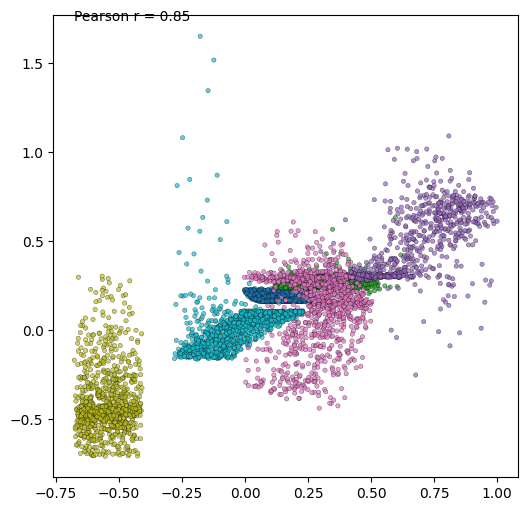

In [20]:
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams['figure.dpi'] = 100
y = sim_data.y
sns.scatterplot(
    x=y.reshape(-1), 
    y=y_pred.reshape(-1), s=10, 
    c=sim_data.adata.obs['sim_cluster'].values[:], cmap=cmap, edgecolor='black', linewidth=0.25, alpha=0.7)

corr, _ = pearsonr(y.reshape(-1), y_pred.reshape(-1))
plt.text(
    x=y.min(), 
    y=y_pred.max()+0.15, 
    s=f'Pearson r = {corr:.2f}', 
    fontsize=10, 
    fontname='DejaVu Sans',
    ha='left',
    va='top'
)
plt.show()

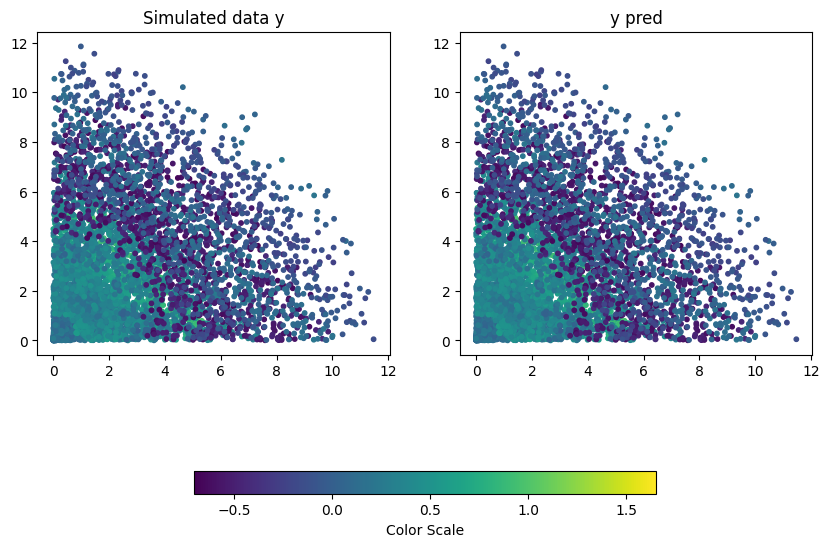

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

vmin = min(np.min(sim_data.y), np.min(y_pred))
vmax = max(np.max(sim_data.y), np.max(y_pred))

sc1 = axes[0].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[0].set_title("Simulated data y")

sc2 = axes[1].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[1].set_title("y pred")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

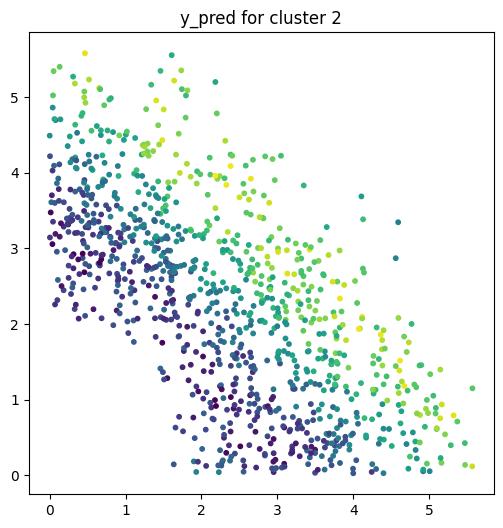

In [22]:
cool_cluster = 2
indices = np.argwhere(sim_data.labels == cool_cluster).flatten()
plt.scatter(sim_data.xy[:, 0][indices], sim_data.xy[:, 1][indices], c=sim_data.y[indices], s=10)
_ = plt.title(f'y_pred for cluster {cool_cluster}')

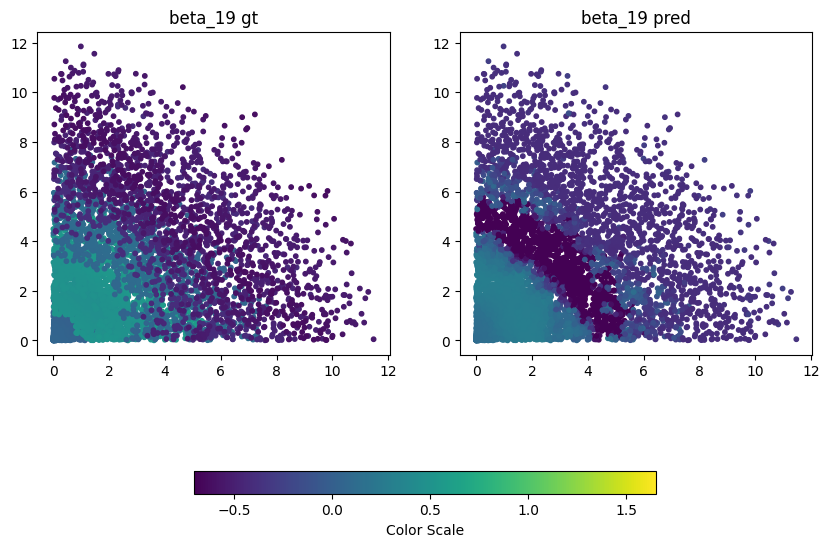

In [27]:
hot_beta = 19

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
vmin = min(np.min(sim_data.y), np.min(y_pred))
vmax = max(np.max(sim_data.y), np.max(y_pred))

sc1 = axes[0].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=sim_data.betas[:, hot_beta], vmin=vmin, vmax=vmax, s=10)
axes[0].set_title(f"beta_{hot_beta} gt")

sc2 = axes[1].scatter(sim_data.xy[:, 0], sim_data.xy[:, 1], c=beta_pred[:, hot_beta], vmin=vmin, vmax=vmax, s=10)
axes[1].set_title(f"beta_{hot_beta} pred")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

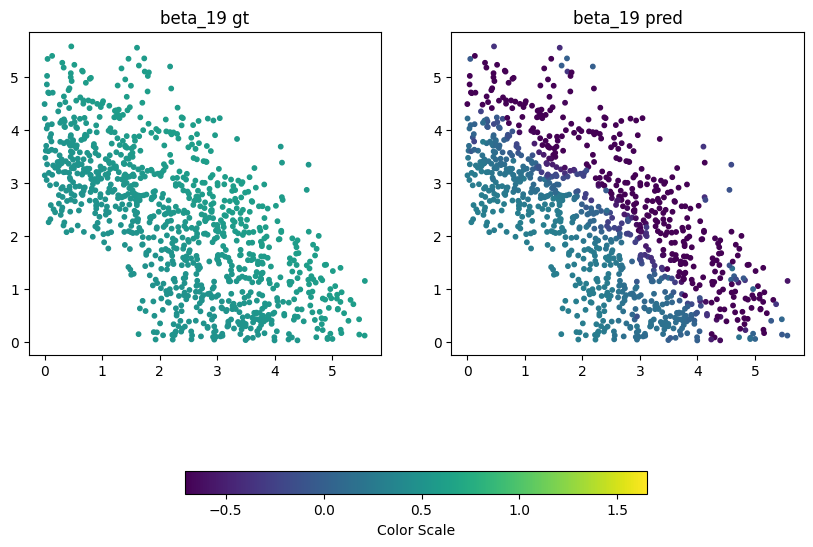

In [28]:
hot_beta = 19
cool_cluster = 2
indices = np.argwhere(sim_data.labels == cool_cluster).flatten()

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
vmin = min(np.min(sim_data.y), np.min(y_pred))
vmax = max(np.max(sim_data.y), np.max(y_pred))

sc1 = axes[0].scatter(sim_data.xy[:, 0][indices], sim_data.xy[:, 1][indices], 
                    c=sim_data.betas[:, hot_beta][indices], vmin=vmin, vmax=vmax, s=10)
axes[0].set_title(f"beta_{hot_beta} gt")

sc2 = axes[1].scatter(sim_data.xy[:, 0][indices], sim_data.xy[:, 1][indices], 
                    c=beta_pred[:, hot_beta][indices], vmin=vmin, vmax=vmax, s=10)
axes[1].set_title(f"beta_{hot_beta} pred")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

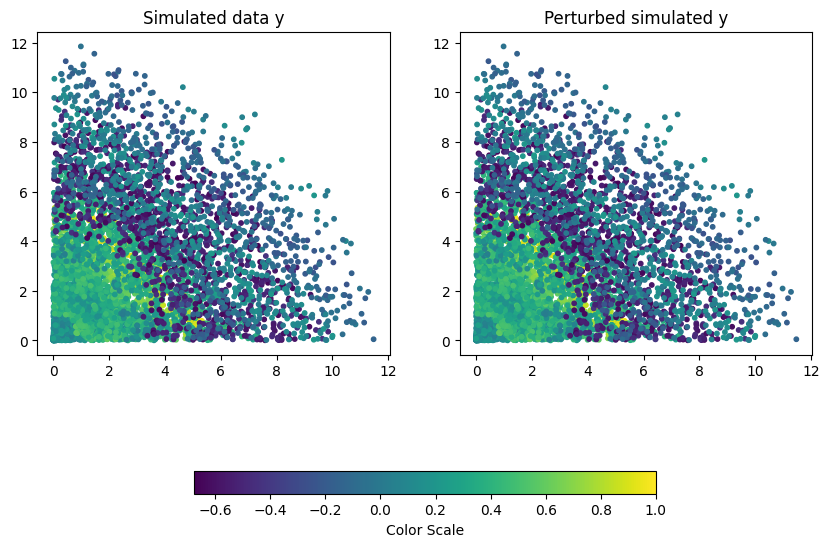

In [25]:
# Simulate KO

tf_ko = 'tf_18'
psim_data = check_betas.perturb(sim_data, tf_ko)

fig, axes = plt.subplots(1, 2, figsize=(10, 6))
vmin = min(np.min(psim_data.y), np.min(sim_data.y))
vmax = max(np.max(psim_data.y), np.max(sim_data.y))

sc1 = axes[0].scatter(psim_data.xy[:, 0], psim_data.xy[:, 1], c=sim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[0].set_title("Simulated data y")

sc2 = axes[1].scatter(psim_data.xy[:, 0], psim_data.xy[:, 1], c=psim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[1].set_title("Perturbed simulated y")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()

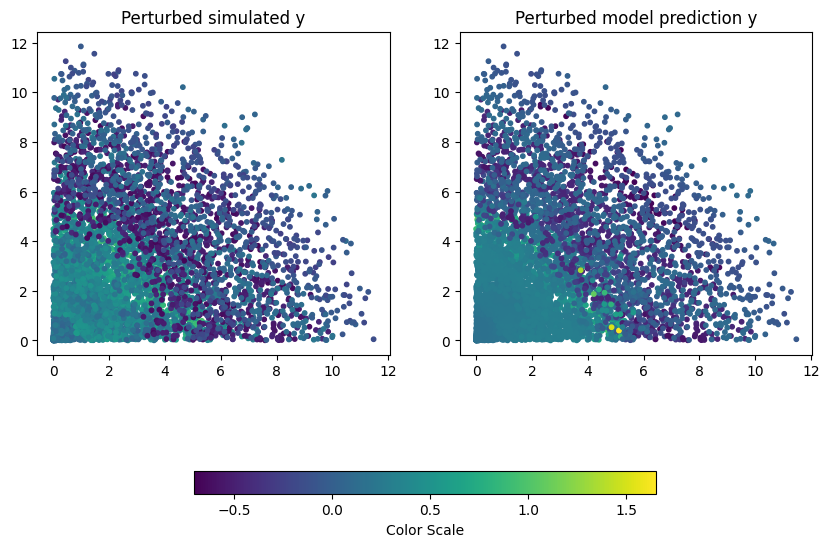

In [26]:
# Model prediction of KO

py_pred = estimator.predict_y(
        estimator.model, 
        torch.from_numpy(beta_pred).cuda(), 
        torch.from_numpy(psim_data.adata.to_df()[estimator.regulators].values).cuda()).cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

vmin = min(np.min(py_pred), np.min(psim_data.y))
vmax = max(np.max(py_pred), np.max(psim_data.y))

sc1 = axes[0].scatter(psim_data.xy[:, 0], psim_data.xy[:, 1], c=psim_data.y, vmin=vmin, vmax=vmax, s=10)
axes[0].set_title("Perturbed simulated y")

sc2 = axes[1].scatter(psim_data.xy[:, 0], psim_data.xy[:, 1], c=py_pred, vmin=vmin, vmax=vmax, s=10)
axes[1].set_title("Perturbed model prediction y")

cbar = fig.colorbar(sc1, ax=axes, orientation='horizontal', fraction=0.05, pad=0.25)
cbar.set_label('Color Scale')

plt.show()